# Overview
- Kaggle の jigsaw-toxic-severity-rating コンペ。
- EDA
    - Dataset overview
- data cleaning
- learning strategy
    - binary classification
- CV strategy

TODO
- cleaning
    - NLTK, Spacy, Keras, torchtext を使う方法があるらしい。。
- feature extraction:
    - BoW
    - TF-IDF
    - N-gram
    - sentiment and intent analysis
- training:
    - naive bayes
    - logistic regression
    - sgd classifier
    - random forest

### References
- [Jiggsaw Toxic Comments EDA & Twitch Stream | Kaggle](https://www.kaggle.com/robikscube/jiggsaw-toxic-comments-eda-twitch-stream)
- data cleaning and kfold [Fold is Gold 🌟 [ cleaned data ] | Kaggle](https://www.kaggle.com/kishalmandal/fold-is-gold-cleaned-data)
- data cleaning and vectorize(TF-IDF, word2vec, BERT) [Text Classification with NLP: Tf-Idf vs Word2Vec vs BERT | toward data science](https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794)
- [Jigsaw CV strategy | Kaggle](https://www.kaggle.com/its7171/jigsaw-cv-strategy)
- [MaxDiffのスコア計算ロジックを教えて下さい。 | Marketing Technology](https://m-te.com/maxdiff-score-logic-200625/)

## Directories

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/jigsaw-toxic-severity-rating/sample_submission.csv
/kaggle/input/jigsaw-toxic-severity-rating/validation_data.csv
/kaggle/input/jigsaw-toxic-severity-rating/comments_to_score.csv


## Parameters

In [2]:
DEBUG_FLAG = False
VERSION = 'nb01'

SUBMISSION_PATH = '/kaggle/input/jigsaw-toxic-severity-rating/sample_submission.csv'
VALIDATION_DATA_PATH = '/kaggle/input/jigsaw-toxic-severity-rating/validation_data.csv'
COMMENTS_SCORE_PATH = '/kaggle/input/jigsaw-toxic-severity-rating/comments_to_score.csv'

## Installs & imports

In [3]:
import datetime
import json
import pickle
import random
import re
import sys
import time

import datatable as dt
import gensim
import gensim.downloader as gensim_api
import lightgbm as lgb
import matplotlib as mpl
import matplotlib.pyplot as plt
import nltk
import numpy as np
import optuna
import pandas as pd
import scipy.stats as ss
import seaborn as sns
import transformers


from catboost import CatBoostClassifier
from contextlib import contextmanager
from lime import lime_text
from logging import getLogger, Formatter, FileHandler, StreamHandler, INFO, DEBUG
from matplotlib_venn import venn2
# from optuna.integration import lightgbm as lgb
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

# settings
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

## Functions

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df


def create_logger(exp_version):
    log_file = (f'{exp_version}.log')

    logger_ = getLogger(exp_version)
    logger_.setLevel(DEBUG)

    # formatter
    # fmr = Formatter('[%(levelname)s] %(asctime)s >>\t%(message)s')
    fmr = Formatter(
        '%(asctime)s %(name)s %(lineno)d'
        ' [%(levelname)s][%(funcName)s] %(message)s'
    )

    # file handler
    fh = FileHandler(log_file)
    fh.setLevel(DEBUG)
    fh.setFormatter(fmr)

    # stream handler
    ch = StreamHandler()
    ch.setLevel(INFO)
    ch.setFormatter(fmr)

    logger_.addHandler(fh)
    logger_.addHandler(ch)


def get_logger(exp_version):
    return getLogger(exp_version)


def get_args_of_func(f):
    return f.__code__.co_varnames[:f.__code__.co_argcount]


def show_mem_usage():
    print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
    print(" ------------------------------------ ")
    for var_name in globals():
        if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 1024**2:
            print("{}{: >25}{}{: >6} MiB{}".format('|',var_name,'|', int(sys.getsizeof(eval(var_name))/1024**2),'|'))


def read_data():
    valid_data = dt.fread(VALIDATION_DATA_PATH).to_pandas()
    score_data = dt.fread(COMMENTS_SCORE_PATH).to_pandas()
    submission = dt.fread(SUBMISSION_PATH).to_pandas()
    return valid_data, score_data, submission


def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    # clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    
    # remove numbers
    text = re.sub(r'[\d]', '', text)
            
    # Tokenize (convert from string to list)
    lst_text = text.split()
    # remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
                
    # Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    # Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    # back to string from list
    text = ' '.join(lst_text)
    return text

## Preparing

In [5]:
create_logger(VERSION)

## Dataset overview

In [6]:
valid_data, comments_score, submission = read_data()

get_logger(VERSION).info(f'validation data shape: {valid_data.shape}')
get_logger(VERSION).info(f'comments score shape: {comments_score.shape}')
get_logger(VERSION).info(f'submission sample shape: {submission.shape}')

2021-11-25 15:35:02,912 nb01 3 [INFO][<module>] validation data shape: (30108, 3)
2021-11-25 15:35:02,914 nb01 4 [INFO][<module>] comments score shape: (7537, 2)
2021-11-25 15:35:02,915 nb01 5 [INFO][<module>] submission sample shape: (7537, 2)


In [7]:
display(valid_data.head())
display(comments_score.head())
display(submission.head())

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"


,comment_id,text
0,114890,"""\n \n\nGjalexei, you asked about whether ther..."
1,732895,"Looks like be have an abuser , can you please ..."
2,1139051,I confess to having complete (and apparently b...
3,1434512,"""\n\nFreud's ideas are certainly much discusse..."
4,2084821,It is not just you. This is a laundry list of ...


,comment_id,score
0,114890,0.5
1,732895,0.5
2,1139051,0.5
3,1434512,0.5
4,2084821,0.5


In [8]:
get_logger(VERSION).info(f"number of unique text in validation data: {pd.concat([valid_data['less_toxic'], valid_data['more_toxic']]).nunique()}")
get_logger(VERSION).info(f"number of unique text in scoring data: {comments_score['text'].nunique()}")
get_logger(VERSION).info(f"number of workers in validation data: {valid_data['worker'].nunique()}")

2021-11-25 15:35:03,186 nb01 1 [INFO][<module>] number of unique text in validation data: 14250
2021-11-25 15:35:03,200 nb01 2 [INFO][<module>] number of unique text in scoring data: 7536
2021-11-25 15:35:03,203 nb01 3 [INFO][<module>] number of workers in validation data: 753


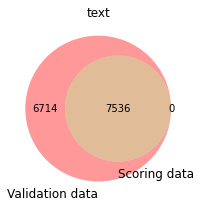

In [9]:
# comparrable annotation のテキストと、テスト用データセット内のテキストの重複を確認
valid_text = pd.DataFrame(pd.concat([valid_data['less_toxic'], valid_data['more_toxic']]).unique(), columns=['text'])

plt.figure(figsize=(3,3))
venn2(subsets=(set(valid_text['text'].unique()), 
               set(comments_score['text'].unique())),
      set_labels=('Validation data', 'Scoring data'))
plt.title('text')
plt.tight_layout()
plt.show()

スコアリング対象となるテキストは、すべて学習データに含まれている。

In [10]:
# comparable annotation 内に同一テキストが何回出現しているか
n_text_appear = pd.concat([valid_data['less_toxic'], valid_data['less_toxic']]).value_counts().to_frame()
display(n_text_appear)

,less_toxic
"sorry i jumped to conclusions \n\non christian terrorism article man, I don't agree with you, and I want you to go and listen to 'prophet of doom' (now in audio format) as it is good. But I was wrong to be so rude. It is not the Southern European way.",26
How many sockpuppets do you have?,26
this irishtom guy is turning every article into an ad for islam,24
I erased your cuss word\nFrom: some random person out there in the world,24
"An addition comment of interest by Andrew Coyne National Post Dec 7th regarding Dion's dual citizenship-“Anyone who questions Stephan Dion’s patriotism is either a fool or a scoundrel. After the service he has done this country, after the abuse he has suffered in its name, to cast even the slightest doubt on his loyalty to Canada shames those who would try. There can be few Canadians who believe in their country more, or have done more to defend it.” \nThis tactic that the PC's are using regarding the citizenship issue is very much a copy of the Republic book. If somewhere an article or sourced information could be found it could be of interest to add as a counterbalance.",24
...,...
"""\n\n ********************BABY EATERS????******************** \n\nAlright is it true that some of the band's songs translate into lyrics like """"I'm going to cut open your fetus, and eat your baby"""" ? Or other horrific lyrics?""",2
Screw them all. I'm out of here. IDcab and their new found attack dog jossi have won. Adios.,2
marathas are not rajputs \n\nMarathas are not rajputs. This article has lot of false information. In fact marathas defeated rajputs many times. Rajputs made alliance with muslims\nfor defeating muslim invaders.,2
"Assalam-o-Alikum (Peace Be Upon You) \n\nI am back. But let me tell you, I was evenO.k while I was blocked, because my conscience was still alive.\n\nAnyhow, against your kindness, I wish if we could be friends.\n\nThanking youin anticipation,\n\nA M. Khan\n",2


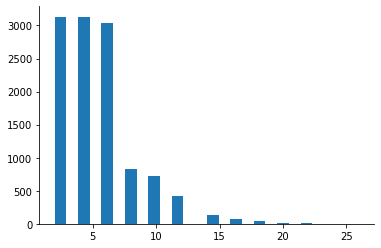

In [11]:
# comparable annotation 内のテキストの出現回数をヒストグラムで確認
plt.hist(n_text_appear, bins=n_text_appear['less_toxic'].max())
plt.show()

In [12]:
print(n_text_appear.value_counts())

less_toxic
4             3132
2             3123
6             3033
8              827
10             725
12             421
14             129
16              67
18              41
20              16
22              11
24               4
26               2
dtype: int64


- テキストには、改行記号 "\n" がそのまま入っているため、クリーニングが必要。
- テキストが評価されるのは偶数回。
- テキストが評価に使用された回数は、2, 4, 6回が多い。

737    248
461    240
114    228
728    221
639    216
Name: worker, dtype: int64


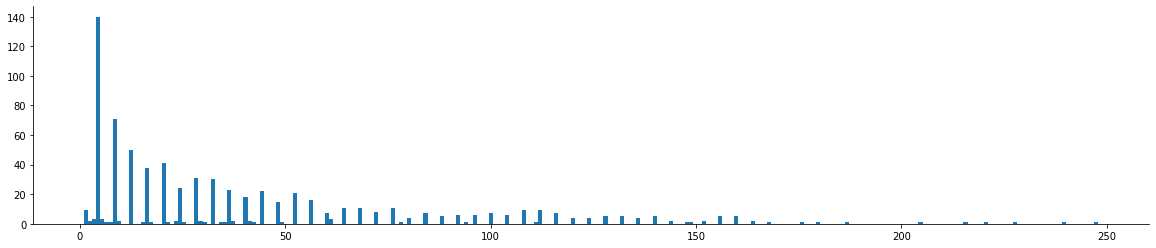

In [13]:
# worker が何回評価したかをヒストグラムにする
n_valid_worker = valid_data['worker'].value_counts()
print(n_valid_worker.head())

plt.figure(figsize=(20, 4))
plt.hist(n_valid_worker, bins=max(n_valid_worker))
plt.show()

737番の worker がテキストを比較評価した回数が最も多く248回。  
ついで461番の worker で240回。  

In [14]:
print(n_valid_worker.value_counts())

4      140
8       71
12      50
20      41
16      38
28      31
32      30
24      24
36      23
44      22
52      21
40      18
56      16
48      15
64      11
76      11
68      11
112      9
108      9
1        9
72       8
84       7
116      7
60       7
100      7
92       6
104      6
96       6
160      5
140      5
88       5
128      5
132      5
156      5
124      4
80       4
136      4
120      4
3        3
5        3
61       3
2        2
9        2
23       2
29       2
164      2
37       2
41       2
144      2
152      2
42       1
17       1
111      1
94       1
228      1
78       1
6        1
7        1
221      1
240      1
216      1
15       1
205      1
187      1
21       1
180      1
25       1
176      1
148      1
30       1
168      1
34       1
35       1
149      1
49       1
248      1
Name: worker, dtype: int64


worker がテキストを比較評価した回数のヒストグラムをみると、4回評価した worker が最も多く140人。  
ついで8回が多く71人。

In [15]:
valid_data.head()

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"


In [16]:
# text 出現数, less 評価数、 more 評価数を集計して toxic_ratio を計算
less_toxic_text = valid_data['less_toxic'].to_frame(name='text')
less_toxic_text = less_toxic_text.assign(valid = 0)
more_toxic_text = valid_data['more_toxic'].to_frame(name='text')
more_toxic_text = more_toxic_text.assign(valid = 1)

all_text = pd.concat([less_toxic_text, more_toxic_text], axis=0)

all_text = all_text.groupby('text').agg(
    ['count', 
     ('more', lambda x: (x==1).sum()), 
     ('less', lambda x: (x==0).sum())]
).sort_values(('valid', 'count'), ascending=False)

all_text['toxic_ratio'] = all_text[('valid', 'more')] / all_text[('valid', 'count')]
all_text.sort_values(['toxic_ratio', ('valid', 'count')], ascending=False).sample(n=10).style.bar(subset=['toxic_ratio'], color='#205ff2')

0.333333    3256
0.666667    3229
1.000000    2719
0.000000    2572
0.500000     735
0.166667     578
0.833333     462
0.444444     141
0.555556     127
0.222222      98
Name: toxic_ratio, dtype: int64


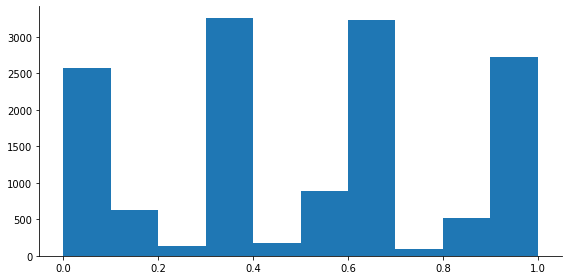

In [17]:
# toxic_ratio の分布を確認
print(all_text['toxic_ratio'].value_counts().head(10))

fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True, figsize=(8, 4))
ax.hist(all_text['toxic_ratio'], bins=10)
plt.show()

In [18]:
print(all_text['toxic_ratio'].value_counts())

0.333333    3256
0.666667    3229
1.000000    2719
0.000000    2572
0.500000     735
0.166667     578
0.833333     462
0.444444     141
0.555556     127
0.222222      98
0.777778      77
0.888889      57
0.111111      50
0.250000      33
0.416667      25
0.750000      15
0.583333      13
0.916667       9
0.083333       9
0.400000       5
0.857143       4
0.714286       4
0.533333       4
0.142857       3
0.285714       3
0.428571       3
0.571429       3
0.933333       2
0.800000       2
0.600000       2
0.466667       2
0.100000       1
0.388889       1
0.277778       1
0.733333       1
0.461538       1
0.133333       1
0.200000       1
0.266667       1
Name: toxic_ratio, dtype: int64


- 分布のピークが4つある。これは評価される数が原因か。

## Clearning

**stemming**  
stem は日本語では "語幹" の意味。  
NLP で steming というと、単語の語形変化の基礎部分に変形する。  
たとえば、connect に関連する単語は、steming により以下のように変形される。
```py
>>> from nltk.stem import PorterStemmer
>>> porter = PorterStemmer()
>>> word_list = ["connected", "connecting", "connection", "connections"]
>>>
>>> for word in word_list:
...     print(porter.stem(word))
...
connect
connect
connect
connect
```

In [19]:
# english stop words のリストを作成
stop_words = list(text.ENGLISH_STOP_WORDS)
get_logger(VERSION).info(len(stop_words))
get_logger(VERSION).info(' '.join(stop_words))

2021-11-25 15:35:10,670 nb01 3 [INFO][<module>] 318
2021-11-25 15:35:10,671 nb01 4 [INFO][<module>] can more whereas call your yours i our within front well twenty thereupon twelve yourself whence de among further own his thereafter besides all an nobody detail sincere the therefore thru at those go found first seems hers since un during then move find ever amoungst seemed sometime else interest in cant moreover forty on become he either seem there somehow anything mine these because its would please where such two less nor done elsewhere who must six namely are four myself side many cannot out former that wherein behind both formerly put also again everything due whether and hereupon hence if everyone most ltd too whom whole whatever ie we could ten by mill still per no seeming this may together herself from whither what beside them three being next when throughout along becomes whenever con sometimes how fifty about over perhaps not were keep whoever themselves none latter me back gi

In [20]:
# html タグとその他の消去する単語のリスト
html_tags = ['<p>', '</p>', '<table>', '</table>', '<tr>', '</tr>', '<ul>', '</ul>', '<ol>', '</ol>', '<dl>', '</dl>', \
             '<li>', '</li>', '<dd>', '</dd>', '<dt>', '</dt>', '/n', '\n']
r_buf = ['it', 'is', 'are', 'do', 'does', 'did', 'was', 'were', 'will', 'can', 'the', 'a', 'of', 'in', 'and', 'on', \
         'what', 'where', 'when', 'which']
to_remove = list(set(stop_words + html_tags + r_buf))

In [21]:
# テキストをクリーニング
valid_data['less_toxic_clean'] = valid_data['less_toxic'].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=to_remove))
valid_data['more_toxic_clean'] = valid_data['more_toxic'].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=to_remove))
comments_score['text_clean'] = comments_score['text'].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=to_remove))

display(valid_data.head())
display(comments_score.head())

,worker,less_toxic,more_toxic,less_toxic_clean,more_toxic_clean
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...,article suck woo woo wooooooo,wher sexy pic gone main page
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...,yes people recognize usually dont objection he...,daphne guinness mornin favourite alien life fo...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu...",western medium yup crime entire world caused w...,atom dont believe actual photo masturbation se...
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...,removed numbskull dont care say anymore life a...,sand vagina want wash stinking hole bitch
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist",smelly vagina bluerasberry dont model cheesy b...,hey way support nazi racist


,comment_id,text,text_clean
0,114890,"""\n \n\nGjalexei, you asked about whether ther...",gjalexei asked antieditorializing policy calle...
1,732895,"Looks like be have an abuser , can you please ...",look like abuser look thanks
2,1139051,I confess to having complete (and apparently b...,confess having complete apparently blissful ig...
3,1434512,"""\n\nFreud's ideas are certainly much discusse...",freud idea certainly discussed today agree gra...
4,2084821,It is not just you. This is a laundry list of ...,just laundry list stupid allegation scooped go...


とりあえずの特徴量抽出の考え方
- train の text から test の text を除く必要はない。
- X_train と X_test の分布差は確認する必要がある。

In [22]:
# クリーニングしたテキストを使って訓練用データセットとテスト用データセットをつくる
X_train = pd.concat([valid_data['less_toxic_clean'], valid_data['more_toxic_clean']])
y_train = np.vstack([np.zeros(shape=(len(valid_data['less_toxic_clean']), 1)),
                     np.ones(shape=(len(valid_data['more_toxic_clean']), 1))])
X_test = comments_score['text_clean']

get_logger(VERSION).info(f"X_train shape: {X_train.shape}")
get_logger(VERSION).info(f"y_train shape: {y_train.shape}")
get_logger(VERSION).info(f"X_test shape: {X_test.shape}")

2021-11-25 15:35:43,885 nb01 7 [INFO][<module>] X_train shape: (60216,)
2021-11-25 15:35:43,886 nb01 8 [INFO][<module>] y_train shape: (60216, 1)
2021-11-25 15:35:43,888 nb01 9 [INFO][<module>] X_test shape: (7537,)


In [23]:
display(X_train.head())
display(X_test.head())

0                        article suck woo woo wooooooo
1    yes people recognize usually dont objection he...
2    western medium yup crime entire world caused w...
3    removed numbskull dont care say anymore life a...
4    smelly vagina bluerasberry dont model cheesy b...
dtype: object

0    gjalexei asked antieditorializing policy calle...
1                         look like abuser look thanks
2    confess having complete apparently blissful ig...
3    freud idea certainly discussed today agree gra...
4    just laundry list stupid allegation scooped go...
Name: text_clean, dtype: object

## Feature extraction

In [24]:
cnt_vec = CountVectorizer(min_df=3)
X_test = cnt_vec.fit_transform(X_test).toarray()
X_train = cnt_vec.transform(X_train).toarray()

get_logger(VERSION).info(f"X_train shape: {X_train.shape}")
get_logger(VERSION).info(f"X_test shape: {X_test.shape}")
get_logger(VERSION).info(' '.join(cnt_vec.get_feature_names()))

2021-11-25 15:35:48,589 nb01 5 [INFO][<module>] X_train shape: (60216, 7577)
2021-11-25 15:35:48,590 nb01 6 [INFO][<module>] X_test shape: (7537, 7577)
2021-11-25 15:35:48,599 nb01 7 [INFO][<module>] aa aaron abandon abandoned abd abducted abhor abide ability able abnormal abortion abovementioned absence absolute absolutely absolutly absurd absurdity abuse abused abuser abusing abusive academia academic academy accept acceptable acceptance accepted accepting access accessible accident accidentally accomplish accomplished accomplishment accordance according account accountable accuracy accurate accurately accusation accuse accused accuser accuses accusing achieve achieved achievement acid acknowledge acknowledged acknowledgement acknowledging aclu acne acorn acquisition acronym act acted acting action active actively activist activity actor actress actual actually ad adam add added adding addition additional additionally address addressed addressing adequate adequately adjective adjust 

In [25]:
# 特徴量の値がすべて0になったサンプルの数を確認
print(sum(X_train.sum(axis=1)==0))
print(sum(X_test.sum(axis=1)==0))

162
16


In [26]:
# X_train と X_test の分布差を確認
df_mean_lift = pd.DataFrame(index=cnt_vec.get_feature_names(), columns=['X_train_feature_mean', 'X_test_feature_mean', 'lift'])

for i, word in enumerate(cnt_vec.get_feature_names()):
        df_mean_lift.loc[word, 'X_train_feature_mean'] = X_train[:, i].mean()
        df_mean_lift.loc[word, 'X_test_feature_mean'] = X_test[:, i].mean()

df_mean_lift['lift'] = df_mean_lift['X_train_feature_mean'] / df_mean_lift['X_test_feature_mean']
df_mean_lift.query('X_train_feature_mean != 0.0 and X_test_feature_mean != 0.0').sort_values('lift', ascending=False).head(40).style.bar(subset=['lift'], color='#205ff2')

,X_train_feature_mean,X_test_feature_mean,lift
nipple,0.106317,0.000796,133.552195
heil,0.038860,0.000663,58.577720
smell,0.077919,0.002388,32.626622
youi,0.022768,0.000796,28.600447
spanish,0.048293,0.003848,12.551135
anal,0.037864,0.003184,11.890777
atheist,0.029444,0.003184,9.246643
di,0.009715,0.001327,7.322215
cocksucking,0.010512,0.001592,6.602510
wanker,0.025857,0.003980,6.496119


- nipple は乳首
- heil はナチス式敬礼
- smell は匂い
- youi はわからん

## Training

In [27]:
%%time

models = [
    MultinomialNB(), 
    LogisticRegression(solver='liblinear'), 
    SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3, n_jobs=-1), 
    RandomForestClassifier(n_estimators=100, max_depth=32, n_jobs=-1),
    # KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    # KNeighborsClassifier(n_neighbors=7, n_jobs=-1),
    # KNeighborsClassifier(n_neighbors=9, n_jobs=-1)
]

for model in models:
    print(model)
    model.fit(X_train, y_train.ravel())

MultinomialNB()
LogisticRegression(solver='liblinear')
SGDClassifier(loss='modified_huber', n_jobs=-1)
RandomForestClassifier(max_depth=32, n_jobs=-1)
CPU times: user 6min 13s, sys: 2.25 s, total: 6min 15s
Wall time: 2min 54s


## Inference

In [28]:
%%time

preds = []
for model in models:
    print(model)
    pred = model.predict_proba(X_test)[:, 1]
    preds.append(pred)

MultinomialNB()
LogisticRegression(solver='liblinear')
SGDClassifier(loss='modified_huber', n_jobs=-1)
RandomForestClassifier(max_depth=32, n_jobs=-1)
CPU times: user 1.68 s, sys: 1.06 s, total: 2.74 s
Wall time: 990 ms


In [29]:
y_pred = np.array(preds).T.sum(axis=1) / len(preds)
pd.DataFrame(pd.Series(y_pred.ravel()).describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
0,7537.0,0.463863,0.216296,0.015757,0.29458,0.447237,0.609972,0.979037


In [30]:
submission['score'] = y_pred
submission.head()

,comment_id,score
0,114890,0.196969
1,732895,0.309050
2,1139051,0.198691
3,1434512,0.092089
4,2084821,0.414525


In [31]:
submission.to_csv('submission.csv', index=False)